# Модель маятниковго акселерометра с обратной связью

## Вывод уравнений движения чувствительного элемента маятникового акселерометра с тремя степенями свободы
Рассматривается чувствительный элемент (ЧЭ) маятникового компенсационного акселерометра, который представляет собой массу, закреплённую на упругом подвесе. Гибким элементом служит пара консольных балок.

Предполагается, что маятник является абсолютно твердым телом с заданными массовыми характеристиками. Центр масс (т. $С$) находится в плоскости симметрии пластины и может быть смещен в плоскости $YZ$ на величины $l_y$ и $l_z$. При действии сил $F$ (компенсационная сила), $mu$ и $mg$ ($m$ - масса пластины), обусловленных измеряемым ускорением $u$ и ускорением силы тяжести $g$, перемещение пластины определяется линеной $x_r$ и угловыми $ϑ, γ$ координатами.

Уравнения движения выводятся с помощью уравнений Лагранжа 2-го рода:

$$ \frac{d}{dt} \left(\frac{∂T}{∂\dot{q_j}}\right) - \frac{∂T}{∂q_j} = Q_j, \hspace{5mm}(1)\hspace{5mm} (j=1,2,3)$$

где: $T$ - кинетическая энергия ЧЭ; $Q_j$ - обобщенные силы по соответствующим координатам; $q_j,\dot{q_j}$ - обобщенные координаты и скорости
$$ (q_1 = x_r, \dot{q_1} = \dot{x_r}; q_2 = ϑ, \dot{q_2} = \dot{ϑ}; q_3 = γ, \dot{q_3} = \dot{γ}). $$

## Перечень используемых констант:
$l_b$ - эффективная длина упругого подвеса (длина балки);

$l_{cm}$ - расстояние от конца балки до центра масс;

$l_{y}, l_{z}$ - смещение центра масс вдоль осей $Y, Z$;

$l_{Fy}, l_{Fz}$ - смещение центра приложения компенсационной силы вдоль осей $Y, Z$;

$l_{yс}$ - расстояние от конца балки до геометрического центра емкостного датчика;

$l_{zс}$ - смещение геометрического центра емкостного датчика вдоль оси $Z$;

$m$ - масса ЧЭ;

$J_y, J_z$ - главные центральные моменты инерции ЧЭ вокруг осей $Y, Z$;

$g, u$ - гравитационное и измеряемое ускорения;

$F$ - компенсационная сила обратной связи;

$\begin{bmatrix} k_{11} \ k_{12} \ k_{13} \\ k_{21} \ k_{22} \ k_{23} \\ k_{31} \ k_{32} \ k_{33} \end{bmatrix}$ - матрица коэффициентов жесткости упругого подвеса;

$\begin{bmatrix} d_{11} \ d_{12} \ d_{13} \\ d_{21} \ d_{22} \ d_{23} \\ d_{31} \ d_{32} \ d_{33} \end{bmatrix}$ - матрица коэффициентов демпфирования.


<img src="pic12.png">

<center>Рис. 1. К выводу уравнений движения</center>

Импорт необходимых библиотек и объявление переменных

In [316]:
from sympy import *
import sympy.physics.mechanics as mech
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint
from datetime import datetime
import time
import control
import scipy.signal as signal
mech.init_vprinting()

lb, lcm, ly, lz, lFy, lFz, lyc, lzc = symbols('l_b l_cm l_y l_z l_F_y l_F_z l_yc l_zc') 
m, jy, jz, g, u, F, t, Qx, Qt, Qg = symbols('m J_y J_z g u F t Q_{x_r} Q_ϑ Q_γ')
k11, k12, k13, k21, k22, k23, k31, k32, k33 = symbols('k_11 k_12 k_13 k_21 k_22 k_23 k_31 k_32 k_33')
d11, d12, d13, d21, d22, d23, d31, d32, d33 = symbols('d_11 d_12 d_13 d_21 d_22 d_23 d_31 d_32 d_33')
xr, theta, gamma = symbols('x_r ϑ γ', cls=Function)

dxr = diff(xr(t), t)
dtheta = diff(theta(t), t)
dgamma = diff(gamma(t), t)

Выражения для координат $x, y$ и $z$ центра масс ЧЭ

In [317]:
x = xr(t) + (lcm+ly)*theta(t) + lz*gamma(t)
y = - lb - (lcm+ly)
z = lz

Выражения для линейных скоростей $\dot{x}, \dot{y}$ и $\dot{z}$ центра масс ЧЭ

In [318]:
# Mass center linear velocities
dx = diff(x, t)
dy = diff(y, t)
dz = diff(z, t)

Кинетическая энергия ЧЭ

In [319]:
T = (jy*dgamma**2 + jz*dtheta**2)/2 + m/2*(dx**2 + dy**2 + dz**2)
simplify(T)

Производные от полученного выражения

In [320]:
dTdxr = diff(T, xr(t))
dTddxr = diff(T, dxr)
dtdTdtddxr = diff(dTddxr, t)

dTdtheta = diff(T, theta(t))
dTddtheta = diff(T, dtheta)
dtdTdtddtheta = diff(dTddtheta, t)

dTdgamma = diff(T, gamma(t))
dTddgamma = diff(T, dgamma)
dtdTdtddgamma = diff(dTddgamma, t)

## Определение обощенных сил

Силы, обусловленные жесткостью упругого подвеса

In [321]:
Fbx = k11*xr(t) + k12*theta(t) + k13*gamma(t)
Mbz = k21*xr(t) + k22*theta(t) + k23*gamma(t)
Mby = k31*xr(t) + k32*theta(t) + k33*gamma(t)

Диссипативные силы

In [322]:
Fdx = d11*dxr + d12*dtheta + d13*dgamma
Mdz = d21*dxr + d22*dtheta + d23*dgamma
Mdy = d31*dxr + d32*dtheta + d33*dgamma

Силы, обусловленные действием гравитационного $g$ и измеряемого $u$ ускорений

In [323]:
Fux = m*u
Muz = (lcm+ly)*(m*(u-g*theta(t)))
Muy = lz*(m*u) 

Компенсирующие силы

In [324]:
Fx = F
MFz = Fx * (lcm+lFy)
MFy = Fx * lFz

Обобщенные силы

In [325]:
Qx = Fbx + Fdx - Fux + Fx
Qt = Mbz + Mdz - Muz + MFz
Qg = Mby + Mdy - Muy + MFy

## Уравнения движения ЧЭ

Подставляя частные производные от выражения кинетической энергии $T$ используя $(1)$, а также учитывая соотношения для обобщенных сил, уравнения движения принимают вид

In [326]:
eq_xr = simplify(dtdTdtddxr - dTdxr + Qx)
eq_theta = simplify(dtdTdtddtheta - dTdtheta + Qt)
eq_gamma = simplify(dtdTdtddgamma - dTdgamma + Qg)

## Физические характеристики и константы

In [327]:
constants = {g : 1*9.8066,
    
             # Dimensional characteristics
             lb : 2.3e-3,
             lcm : 5.82483317703009E-03,
             lz : 2e-4,
             ly: 0,
             
             lyc: 7.04143173e-3,
             lzc: 0,
             
             lFy: -0.02483317703009E-03,
             lFz: 0,
    
             # Mass characteristics
             m : 0.42655e-3, #0.39861935e-3, # #
             jy : 5.5e-9, #5.13296360570496e-9, # 
             jz : 4e-9, #3.59519057721415e-9, # 
    
             # Stiffness coefficients
             k11 : 1185.3631, #186.234359, #  #  # from cluster model: 283.389426,
             k12 : -1.36316, #-0.214169487,#  #  # -0.283389404,
             k13 : -0,
             k21 : -1.36316, #-0.214169487, #  #  # -0.283389404,
             k22 : 2.08826e-3,#3.279618832E-04, ##  # 3.774241051E-04,
             k23 : 0,
             k31 : -0,
             k32 : 0,
             k33 : 1.8927e-2, #3.347891918E-03,##  #5.035413242E-03,
             
             # Damping coefficients
             d11 : 1*1.9,
             d12 : 0,
             d13 : 0,
             d21 : 0,
             d22 : 1*6e-5,
             d23 : 0,
             d31 : 0,
             d32 : 0,
             d33 : 1*5e-5,
            }

## Решение стационарных уравнений ЧЭ

In [328]:
subs_dict = {Derivative(xr(t), (t, 2)): 0,
             Derivative(theta(t), (t, 2)): 0,
             Derivative(gamma(t), (t, 2)): 0,
             Derivative(xr(t), t): 0,
             Derivative(theta(t), t): 0,
             Derivative(gamma(t), t): 0,
             F: 0*0.004,
             g :1*9.8066,
             u: 1*9.82
            }

eq_xr_steady = eq_xr.subs(subs_dict)
eq_theta_steady = eq_theta.subs(subs_dict)
eq_gamma_steady = eq_gamma.subs(subs_dict)

steady_state_sol = solve([eq_xr_steady.subs(constants),
                          eq_theta_steady.subs(constants),
                          eq_gamma_steady.subs(constants)],
                         [xr(t), theta(t), gamma(t)])

cap_disp_steady = steady_state_sol[xr(t)] \
+ constants[lyc]*steady_state_sol[theta(t)] \
+ constants[lzc]*steady_state_sol[gamma(t)]
print(f'Перемещение геометрического центра подвижной части датчика угла:\
      {round(cap_disp_steady,7)} м\nпри F={subs_dict[F]} Н и u={subs_dict[u]} м/с^2')

Перемещение геометрического центра подвижной части датчика угла:      0.0004426 м
при F=0.0 Н и u=9.82 м/с^2


Выражение $\ddot{x_r}, \ddot{ϑ}, \ddot{γ} $ для подготовки уравнений к представлению в нормальной форме Коши

In [329]:
sols = solve([eq_xr.subs(constants), eq_theta.subs(constants), eq_gamma.subs(constants)], 
             [Derivative(xr(t), (t, 2)), Derivative(theta(t), (t, 2)), Derivative(gamma(t), (t, 2))])
ddxr = sols[Derivative(xr(t), (t, 2))]
ddtheta = sols[Derivative(theta(t), (t, 2))]
ddgamma = sols[Derivative(gamma(t), (t, 2))]

# Численное интегрирование уравненией движения

In [330]:
def dydt(time, y):
    Xr, ddXr, Theta, ddTheta, Gamma, ddGamma = y
    
    subs_dict = {xr(t): Xr,
                 theta(t): Theta,
                 gamma(t): Gamma,
                 Derivative(xr(t), t): ddXr,
                 Derivative(theta(t), t): ddTheta,
                 Derivative(gamma(t), t): ddGamma,
                 F: 0*0.0063907,  # Compensation force
                 u: 1*9.8  # External acceleration
                }
    
    treated_ddXr = ddxr.subs(subs_dict)
    treated_ddTheta = ddtheta.subs(subs_dict)
    treated_ddGamma = ddgamma.subs(subs_dict)

    return [ddXr,
           treated_ddXr,
           ddTheta,
           treated_ddTheta,
           ddGamma,
           treated_ddGamma]

# Initial conditions
Xr_0 = 0
ddXr_0 = 0
Theta_0 = 0
ddTheta_0 = 0
Gamma_0 = 0
ddGamma_0 = 0

y_0 = (Xr_0, ddXr_0, Theta_0, ddTheta_0, Gamma_0, ddGamma_0)

In [331]:
start_time = datetime.now()
solution = solve_ivp(dydt, t_span=(0, 0.1), y0=y_0, method='LSODA', rtol=1e-6, atol=1e-6)
print('solution time:', datetime.now() - start_time)

solution time: 0:00:02.181009


In [332]:
# Current results
xr_sol = solution.y[0]
theta_sol = solution.y[2]
gamma_sol = solution.y[4]
cap_disp = xr_sol + constants[lyc]*theta_sol + constants[lzc]*gamma_sol

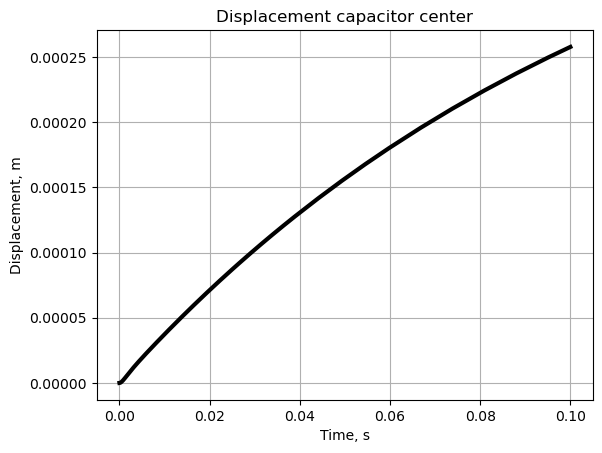

In [333]:
plt.plot(solution.t, cap_disp, 'k', label='LSODA', linewidth=3)
plt.title('Displacement capacitor center')
plt.ylabel('Displacement, m')
plt.xlabel('Time, s')
plt.grid()
plt.show()

# Линеаризация уравнений движения
## Пространство состояний (State-space representation)

В общем виде модель пространства состояний определяется как:
$$ \dot{x}=Ax+Bu $$
$$ y=Cx+Du $$
где $A$ - матрица системы (состояний); $B$ - матрица управления; $С$ - матрица выхода; $D$ - матрица прямой связи; $x$ - вектор состояния; $y$ - вектор выхода; $u$ - вектор управления. 

## Генерирование модели пространства состояний механической части

Формирование матриц $A, B, C$ и $D$

In [334]:
equations = [ddxr, ddtheta, ddgamma]
arguments = [dxr, xr(t), dtheta, theta(t), dgamma, gamma(t)]

# Create A matrix
binary = numpy.diagflat([1,0,1,0,1,0])
A = []
count = 0
for equation in equations:
    row = []
    for argument in arguments:
        coef = equation.coeff(argument)
        row.append(float(coef))
    A.append(row)
    A.append(list(binary[0+count,:]))
    count+=2

# Create B matrix
B = numpy.eye(6,1, dtype=int)
column = [[],[]]
arguments = [F]
for equation in equations:
    count = 0
    for argument in arguments:
        coef = equation.coeff(argument)
        column[count].append([float(coef)])
        column[count].append([0])
        count += 1
B = numpy.append(B, column[0], axis=1)

# Create C and D matrix
C = [[0, 1, 0, constants[lyc], 0, constants[lzc]]]  # xr + lyc*ϑ + lzc*γ
D = [[0, 0]]

Модель механической части акселерометра. 

Имеет два входа: внешнее ускорение $u$, компенсирующая сила $F$ и один выход - линейное перемещение геометрического центра обкладок датчика угла.

In [335]:
mechanics_ss = control.ss(A, B, C, D)
mechanics_ss

<LinearIOSystem:sys[98]:['u[0]', 'u[1]']->['y[0]']>

Ступенчатый отклик модели акселерометра (по первому входу) без обратной связи

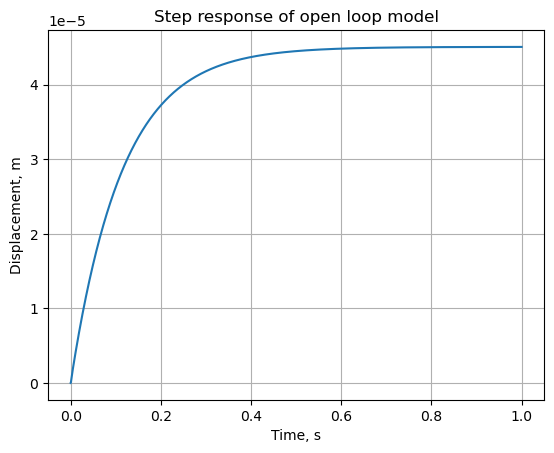

In [336]:
t = numpy.arange(0, 1+1e-5, 1e-5)
_, y = control.step_response(mechanics_ss[0,0], T=t)
plt.plot(t, y)
plt.title('Step response of open loop model')
plt.ylabel('Displacement, m')
plt.xlabel('Time, s')
plt.grid()
plt.show()

ЛАФЧХ (диаграмма Боде)

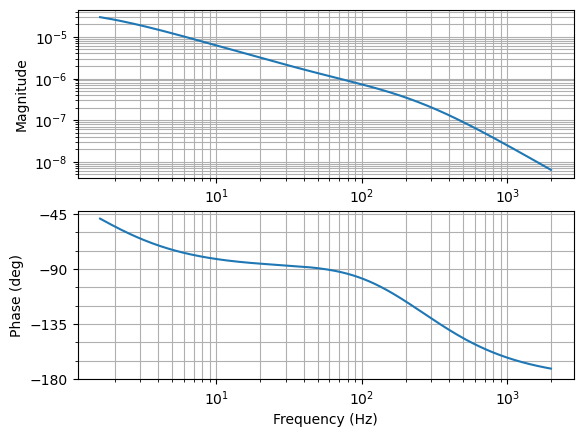

In [337]:
freq_range = numpy.arange(10, 2000*6.28, 1)
mag, phase, omega = control.bode(mechanics_ss[0,0], omega=freq_range, Hz=True, plot=True)

Собственные частоты колебаний

Ввиду того что система передемпфирована, свободных колебаний не происходит. Собственные частоты расчитываются корректно при отсутсвии демпфирования

In [338]:
# Calculate the eigenvalues of the matrix A
eigenvalues = numpy.linalg.eigvals(mechanics_ss.A)

# Natural frequencies in radians per second
eigenfrequencies_rad = numpy.sqrt(numpy.real(eigenvalues)**2 + numpy.imag(eigenvalues)**2)

# Convert to Hz
eigenfrequencies_hz = eigenfrequencies_rad / (2 * numpy.pi)
eigenfrequencies_hz.sort()

print("Собственные частоты системы: \n1:", round(eigenfrequencies_hz[1], 1),
     "Гц\n2:", round(eigenfrequencies_hz[3], 1), "Гц\n3:", round(eigenfrequencies_hz[4], 1), "Гц")

Собственные частоты системы: 
1: 63.0 Гц
2: 277.5 Гц
3: 1384.6 Гц


Отклик на вынужденные колебания

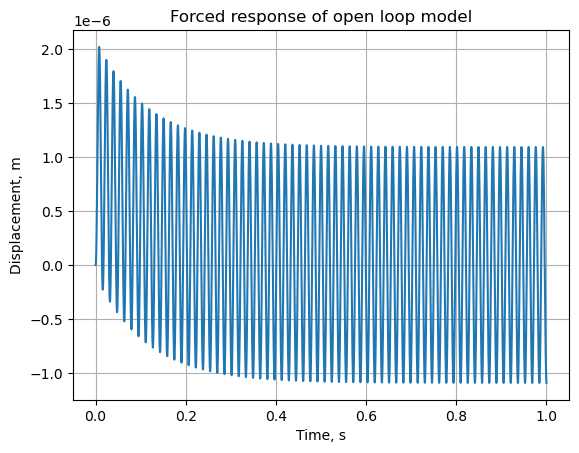

In [339]:
t = numpy.arange(0, 1+1e-5, 1e-5)
w = eigenfrequencies_hz[1]  # frequency, Hz
u = numpy.sin(2 * numpy.pi * w * t)  # Sinusoidal input
_, y = control.forced_response(mechanics_ss[0,0], T=t, U=u)
plt.plot(t, y)
plt.title('Forced response of open loop model')
plt.ylabel('Displacement, m')
plt.xlabel('Time, s')
plt.grid()
plt.show()

## ПИД-регулятор

Для описания усилителя акселерометра используется ПИД-регулятор. Передаточная функция в параллельной форме записывается в виде:
$$ H(s)=K_p+K_i\frac{1}{s}+K_d\frac{N}{1+N\frac{1}{s}}$$
где $K_p$, $K_i$ и $K_d$ - коэффициенты усиления пропорциональной, интегрирующей и дифференцирующей составляющих регулятора соответственно; $N$ - коэффициент фильтрации.

Константы ПИД-регулятора

In [340]:
Kp = 1.3064e+04
Ki = 4.1179e+06
Kd = 1.5735
N = 3.7424e+04

Передаточная функция ПИД-регулятора

In [341]:
PID_tf = control.tf([Kp+N*Kd, Kp*N+Ki, Ki*N], [1, N, 0])
PID_tf

TransferFunction(array([7.19506640e+04, 4.93025036e+08, 1.54108290e+11]), array([1.0000e+00, 3.7424e+04, 0.0000e+00]))

## Временная задеркжа

Для моделирвоания работы усилителя кроме ПИД-регулятора вводится модель временной задержки в виде передаточной функции:
$$H(s)=\frac{y(s)}{u(s)}=e^{-τs}$$
где $τ$ - временная задержка.

Для нахождения числителя и знаменателя передаточной функции используется аппроксимация Паде́:
$$e^{-τs}≈\frac{1-k_1s+k_2s^2+\ldots±k_ns^n}{1+k_1s+k_2s^2+\ldots+k_ns^n}$$
где $n$ - порядок аппроксимации; $k_1,k_2,\ldots$ - константы.

In [342]:
tau = 3.2462e-05
n = 5
[num, den] = control.pade(tau, n)
delay_tf = control.tf(num, den)

## Генерирование модели акселерометра с обратной связью:

Соединение блоков модели (механическая часть и обратная связь)

In [343]:
Q = [[3, 1], [2, 3], [4, 2]]  # Interconnection matrix [input, output]
full_sys_first_out = control.connect(control.append(mechanics_ss, PID_tf, delay_tf), Q, [1], [1])
full_sys_third_out = control.connect(control.append(mechanics_ss, PID_tf, delay_tf), Q, [1], [3])

Полная модель акселерометра с обратной связью выглядит следующим образом:
<img src=block-scheme.png>

Ступенчатый отклик модели акселерометра с обратной связью

/Users/danil/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/matfuncs.py:709: LinAlgWarning: Ill-conditioned matrix (rcond=1.17944e-46): result may not be accurate.
  return solve(Q, P)


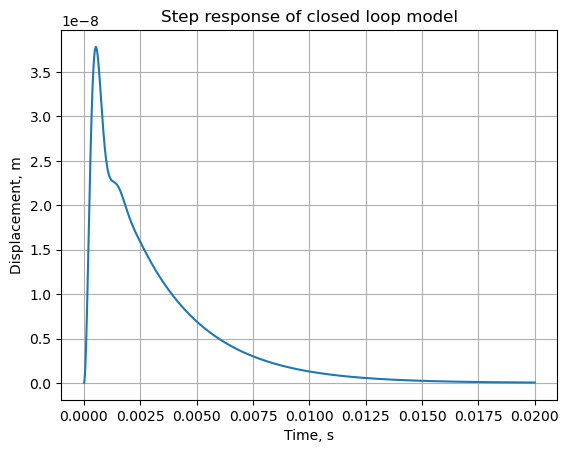

solution time: 0:00:00.102086


In [344]:
start_time = datetime.now()
t = numpy.arange(0, 0.02+1e-5, 1e-5)
_, y = control.step_response(full_sys_first_out, T=t)
plt.plot(t, y)
plt.title('Step response of closed loop model')
plt.ylabel('Displacement, m')
plt.xlabel('Time, s')
plt.grid()
plt.show()
print('solution time:', datetime.now() - start_time)

ЛАФЧХ (диаграмма Боде)

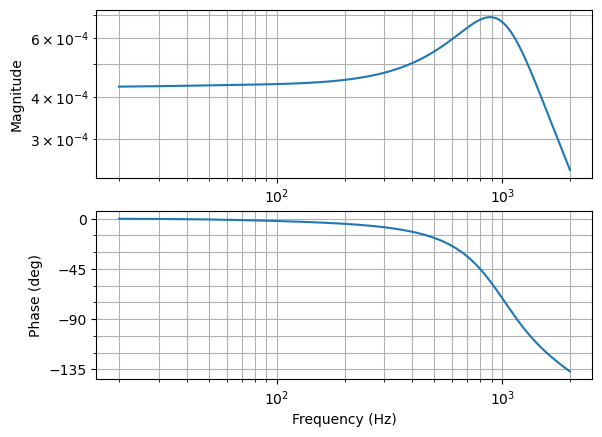

In [345]:
freq_range = numpy.arange(20*6.28, 2000*6.28, 1)
mag, phase, omega = control.bode(full_sys_third_out, omega=freq_range, Hz=True, plot=True)
# plt.plot(freq_range/6.28, mag,  'g:', label='State-space', linewidth=3)
# plt.title('xr')
# plt.ylabel('Displacement, m')
# plt.xlabel('Time, s')
# plt.legend()
# plt.grid()
# plt.show()

Оценка устойчивости. Карта полюсов и нулей

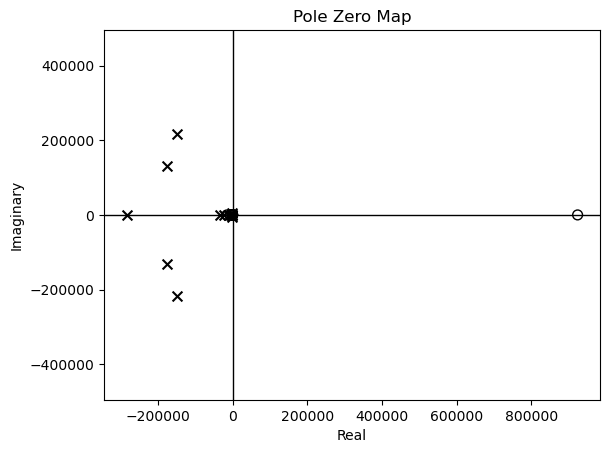

In [346]:
_ = control.pzmap(full_sys_third_out)

Отклик на вынужденные колебания

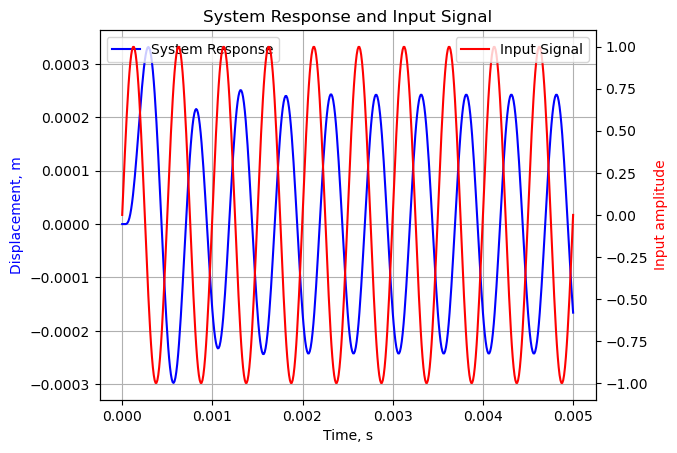

In [359]:
t = numpy.arange(0, 0.005+1e-5, 1e-5)
w = 2000  # frequency, Hz
u = numpy.sin(2 * numpy.pi * w * t)  # Sinusoidal input
_, y = control.forced_response(full_sys_third_out, T=t, U=u)

fig, ax1 = plt.subplots()

# Plot the system response on the first y-axis
ax1.plot(t, y, 'b-', label='System Response')
ax1.set_title('System Response and Input Signal')
ax1.set_ylabel('Displacement, m', color='b')
ax1.set_xlabel('Time, s')
ax1.grid()

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the input on the second y-axis
ax2.plot(t, u, 'r-', label='Input Signal')
ax2.set_ylabel('Input amplitude', color='r')

# Add a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
# Display the plot
plt.show()

## Передаточная функция акселерометра собратной связью
Передаточная функция $H(s)$ в общем виде может быть представлена в виде:
$$H(s)=\frac{y(s)}{u(s)}$$
где $y$ - выходной сигнал; $u$ - входной сигнал системы; $s=σ+jω $ - оператор передаточной функции в преобразовании Лапласа.

Передаточная функция акселерометра с обратной связью:

In [314]:
Hacc = control.ss2tf(full_sys_third_out)
Hacc

TransferFunction(array([ 1.16415322e-10, -7.19506639e+04,  6.60007191e+10, -2.82229859e+16,
        6.87220801e+21, -9.31896628e+26,  5.38017541e+31,  3.92394139e+35,
        1.23019167e+39,  8.38449923e+42,  5.80302855e+45,  2.41685033e+49,
        7.59304121e+51]), array([1.00000000e+00, 9.61581476e+05, 4.33002410e+11, 1.13313638e+17,
       1.72347798e+22, 1.36691779e+27, 2.95695598e+31, 1.54146830e+35,
       1.57331786e+39, 2.96260794e+42, 2.15234610e+46, 1.35745881e+49,
       5.65012058e+52, 1.77381849e+55]))

# Верифицирование механчисекой части без обратной связи

Чтение результатов из файлов

In [ ]:
# Read saved ODE results
ODE_time_0g = numpy.loadtxt('ODE_time_0g.txt')
ODE_xr_0g = numpy.loadtxt('ODE_xr_0g.txt')
ODE_theta_0g = numpy.loadtxt('ODE_theta_0g.txt')
ODE_gamma_0g = numpy.loadtxt('ODE_gamma_0g.txt')

In [ ]:
# Read saved Ansys results
ansys_time = numpy.linspace(5e-5, 0.1, 2000)
ansys_xr_0g = numpy.loadtxt('ansys_xr_0g.txt')
ansys_theta_0g = numpy.loadtxt('ansys_theta_0g.txt')
ansys_gamma_0g = numpy.loadtxt('ansys_gamma_0g.txt')

In [ ]:
# Read saved State-space results
ss_time = numpy.arange(0, 0.1+1e-3, 1e-3)
ss_xr_0g = numpy.loadtxt('ss_xr_0g.txt')
ss_theta_0g = numpy.loadtxt('ss_theta_0g.txt')
ss_gamma_0g = numpy.loadtxt('ss_gamma_0g.txt')

Относительная погрешность

In [ ]:
print('Ansys vs ODE solution')
print('Δxr =', round((min(ODE_xr_0g)-min(ansys_xr_0g))/min(ODE_xr_0g)*100, 2), '%')
print('Δϑ =', round((min(ODE_theta_0g)-min(ansys_theta_0g))/min(ODE_theta_0g)*100, 2), '%')
print('Δγ =', round((min(ODE_gamma_0g)-min(ansys_gamma_0g))/min(ODE_gamma_0g)*100, 2), '%')
print('')
print('ODE solution vs State-space model')
print('Δxr =', round((min(ODE_xr_0g)-min(ss_xr_0g))/min(ss_xr_0g)*100, 2), '%')
print('Δϑ =', round((min(ODE_theta_0g)-min(ss_theta_0g))/min(ss_theta_0g)*100, 2), '%')
print('Δγ =', round((min(ODE_gamma_0g)-min(ss_gamma_0g))/min(ss_gamma_0g)*100, 2), '%')

Перемещение конца балки

In [ ]:
plt.plot(ODE_time_0g, ODE_xr_0g, 'k', label='ODE', linewidth=3)
plt.plot(ansys_time, ansys_xr_0g, '--r', label='Ansys', linewidth=3)
plt.plot(ss_time, ss_xr_0g, 'g:', label='State-space', linewidth=3)
plt.title('xr')
plt.ylabel('Displacement, m')
plt.xlabel('Time, s')
plt.legend()
plt.grid()
plt.show()

Угол поворота вокруг оси Z

In [ ]:
plt.plot(ODE_time_0g, ODE_theta_0g, 'k', label='ODE', linewidth=3)
plt.plot(ansys_time, ansys_theta_0g, '--r',label='Ansys', linewidth=3)
plt.plot(ss_time, ss_theta_0g, 'g:', label='State-space', linewidth=3)
plt.title('ϑ')
plt.ylabel('Angular displacement, rad')
plt.xlabel('Time, s')
plt.legend()
plt.grid()
plt.show()

Угол поворота вокруг оси Y

In [ ]:
plt.plot(ODE_time_0g, ODE_gamma_0g, 'k', label='ODE', linewidth=3)
plt.plot(ansys_time, ansys_gamma_0g, '--r',label='Ansys', linewidth=3)
plt.plot(ss_time, ss_gamma_0g, 'g:', label='State-space', linewidth=3)
plt.title('γ')
plt.ylabel('Angular displacement, rad')
plt.xlabel('Time, s')
plt.legend()
plt.grid()
plt.show()

# Верифицирование модели с обратной связью

<img src=PIDvsFull.jpg>